In [ ]:
# Time Series Anomaly Detection for IoT Sensors

This notebook implements an end-to-end anomaly detection pipeline
for multivariate IoT sensor time-series data as part of the
AI/ML Engineer assignment.

The goal is to detect abnormal sensor behavior that may indicate
equipment failure or maintenance needs.


In [1]:
# Import required libraries
import pandas as pd
# Load the dataset using a relative path 
df = pd.read_csv("iot_sensor_anomaly_dataset.csv")
df.head()


,timestamp,temperature,vibration,pressure,is_anomaly
0,1/1/24 9:00 AM,50.25,4.86,103.55,0
1,1/1/24 9:01 AM,50.25,4.94,102.35,0
2,1/1/24 9:02 AM,50.95,4.67,103.91,0
3,1/1/24 9:03 AM,51.68,4.64,101.87,0
4,1/1/24 9:04 AM,51.08,5.24,103.14,0


In [2]:
# Check the shape of the dataset (rows, columns)
df.shape
# Display column names, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    60 non-null     object 
 1   temperature  60 non-null     float64
 2   vibration    60 non-null     float64
 3   pressure     60 non-null     float64
 4   is_anomaly   60 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 2.5+ KB


In [3]:
# Check for missing values in the dataset
df.isnull().sum()

timestamp      0
temperature    0
vibration      0
pressure       0
is_anomaly     0
dtype: int64

In [ ]:
## Timestamp Parsing

Sensor timestamp data may contain non-uniform datetime formats.
Automatic datetime parsing is used to ensure robustness against
format variations commonly observed in real-world industrial data.


In [4]:
# Convert timestamp column to datetime for time-series analysis
df['timestamp'] = pd.to_datetime(df['timestamp'],infer_datetime_format=True)
# Sort data by timestamp to ensure correct temporal order
df = df.sort_values('timestamp')
# Reset index after sorting
df.reset_index(drop = True ,inplace = True)
# Verify the changes
df.head()

C:\Users\keystone02\AppData\Local\Temp\ipykernel_2792\146093413.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'],infer_datetime_format=True)
C:\Users\keystone02\AppData\Local\Temp\ipykernel_2792\146093413.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'],infer_datetime_format=True)


,timestamp,temperature,vibration,pressure,is_anomaly
0,2024-01-01 09:00:00,50.25,4.86,103.55,0
1,2024-01-01 09:01:00,50.25,4.94,102.35,0
2,2024-01-01 09:02:00,50.95,4.67,103.91,0
3,2024-01-01 09:03:00,51.68,4.64,101.87,0
4,2024-01-01 09:04:00,51.08,5.24,103.14,0


In [5]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better readability
sns.set(style="whitegrid")


In [ ]:
## Data Generation

Synthetic multivariate sensor data was generated to simulate
industrial IoT readings.

Normal behavior consists of smooth periodic patterns with noise.
Anomalies were injected in the form of:
- Sudden spikes
- Sustained deviations (drift)

This provides ground truth labels for objective evaluation,
which is often unavailable in real-world industrial datasets.


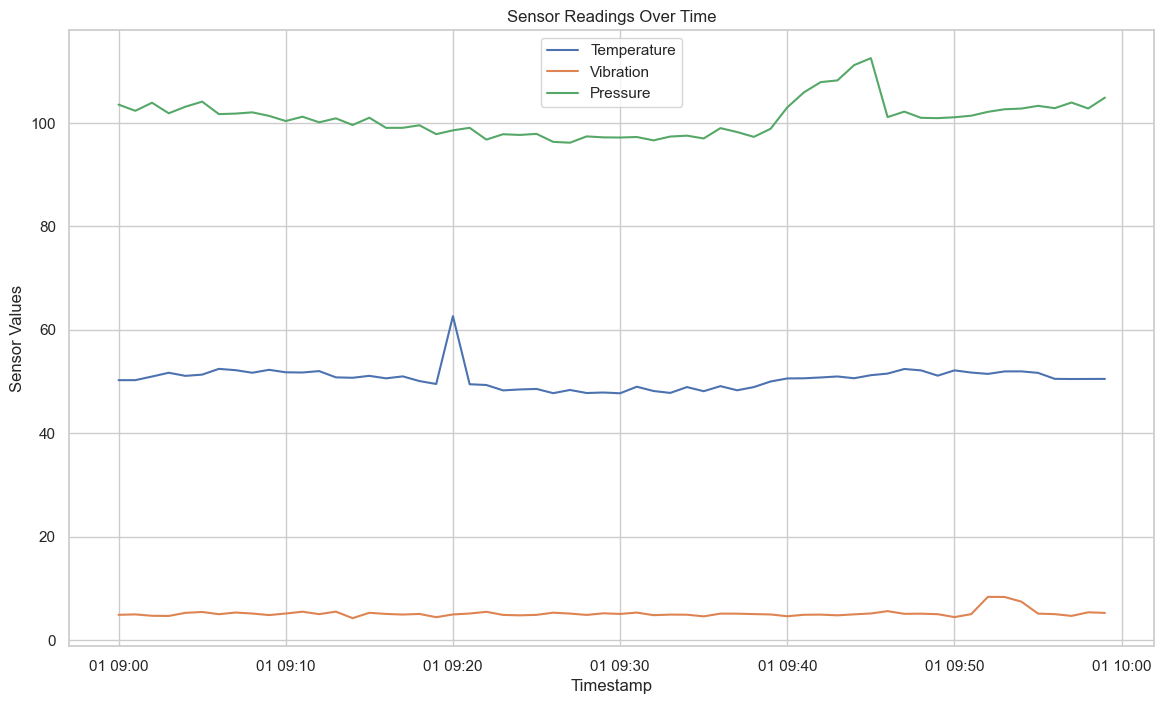

In [6]:
#create a figure with multiple subplots
plt.figure(figsize=(14,8))

#plot temperature
plt.plot(df['timestamp'],df['temperature'],label='Temperature')

#plot vibration
plt.plot(df['timestamp'],df['vibration'],label='Vibration')

#plot pressure
plt.plot(df['timestamp'],df['pressure'],label='Pressure')

#Add labels and title
plt.xlabel("Timestamp")
plt.ylabel("Sensor Values")
plt.title("Sensor Readings Over Time")
plt.legend()

#Display the plot 
plt.show()

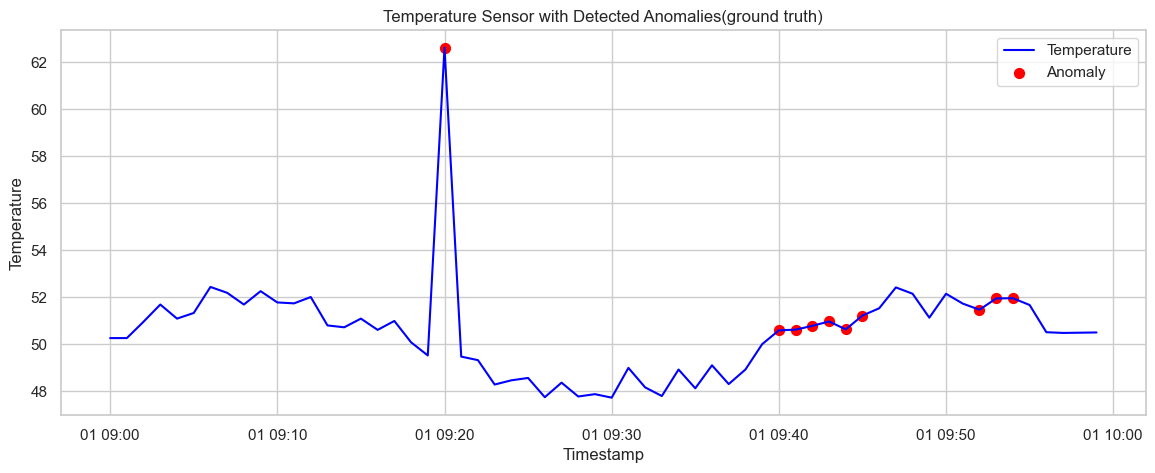

In [7]:
#plot temperature values 
plt.figure(figsize=(14,5))
plt.plot (df['timestamp'],df['temperature'],label = 'Temperature', color='blue')

#overlay anomalies
anomalies = df[df['is_anomaly'] == 1 ]
plt.scatter(anomalies['timestamp'],anomalies['temperature'],color='red',label='Anomaly',s=50)

#Add labels and  legend 
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Temperature Sensor with Detected Anomalies(ground truth)")
plt.legend()

plt.show()


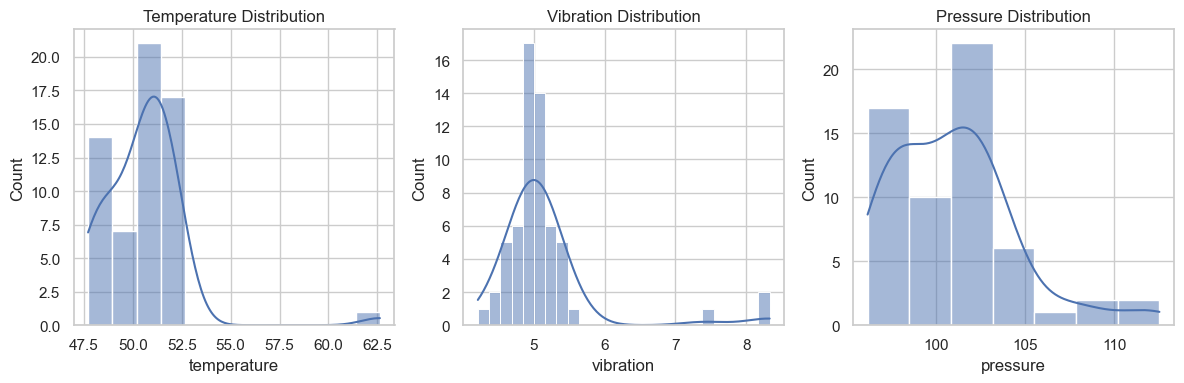

In [8]:
#plot distribution of sensor readings 
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(df['temperature'], kde=True)
plt.title("Temperature Distribution")

plt.subplot(1,3,2)
sns.histplot(df['vibration'], kde=True)
plt.title ("Vibration Distribution")

plt.subplot(1,3,3)
sns.histplot(df['pressure'],kde=True)
plt.title("Pressure Distribution")

plt.tight_layout()
plt.show()


In [ ]:
### Observations
- Normal sensor readings follow smooth periodic trends
- Anomalies appear as abrupt spikes or sustained deviations
- Visual inspection confirms realistic anomaly behavior


In [ ]:
## Feature Engineering

Rolling statistics were created to capture temporal behavior.

- Rolling Mean helps detect gradual drifts
- Rolling Standard Deviation captures abnormal variability
- Raw sensor values preserve original signal characteristics

These features help models detect both sudden and gradual anomalies.


In [9]:
# Create rolling window features
# Rolling statistics help capture short-term trends and volatility

window_size = 5  # small window due to limited dataset size

# Temperature features
df['temp_roll_mean'] = df['temperature'].rolling(window=window_size).mean()
df['temp_roll_std'] = df['temperature'].rolling(window=window_size).std()

# Vibration features
df['vib_roll_mean'] = df['vibration'].rolling(window=window_size).mean()
df['vib_roll_std'] = df['vibration'].rolling(window=window_size).std()

# Pressure features
df['pres_roll_mean'] = df['pressure'].rolling(window=window_size).mean()
df['pres_roll_std'] = df['pressure'].rolling(window=window_size).std()


In [10]:
# Create difference features to capture sudden changes between time steps

df['temp_diff'] = df['temperature'].diff()
df['vib_diff'] = df['vibration'].diff()
df['pres_diff'] = df['pressure'].diff()


In [11]:
# Drop initial rows with NaN values created due to rolling and differencing
df_fe = df.dropna().reset_index(drop=True)

# Verify dataset after feature engineering
df_fe.head()


,timestamp,temperature,vibration,pressure,is_anomaly,temp_roll_mean,temp_roll_std,vib_roll_mean,vib_roll_std,pres_roll_mean,pres_roll_std,temp_diff,vib_diff,pres_diff
0,2024-01-01 09:04:00,51.08,5.24,103.14,0,50.842,0.606523,4.870,0.242281,102.964,0.843078,-0.60,0.60,1.27
1,2024-01-01 09:05:00,51.32,5.41,104.12,0,51.056,0.529273,4.980,0.341248,103.078,0.970963,0.24,0.17,0.98
2,2024-01-01 09:06:00,52.43,4.98,101.71,0,51.492,0.593355,4.988,0.340544,102.950,1.121450,1.11,-0.43,-2.41
3,2024-01-01 09:07:00,52.18,5.30,101.81,0,51.738,0.566851,5.114,0.308513,102.530,1.063790,-0.25,0.32,0.10
4,2024-01-01 09:08:00,51.68,5.11,102.05,0,51.738,0.566851,5.208,0.167242,102.566,1.038619,-0.50,-0.19,0.24


In [12]:
# Select feature columns for modeling
feature_cols = [
    'temperature', 'vibration', 'pressure',
    'temp_roll_mean', 'temp_roll_std',
    'vib_roll_mean', 'vib_roll_std',
    'pres_roll_mean', 'pres_roll_std',
    'temp_diff', 'vib_diff', 'pres_diff'
]

X = df_fe[feature_cols]

# Target label (used only for evaluation, not training)
y = df_fe['is_anomaly']


In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

X_scaled.head()


,temperature,vibration,pressure,temp_roll_mean,temp_roll_std,vib_roll_mean,vib_roll_std,pres_roll_mean,pres_roll_std,temp_diff,vib_diff,pres_diff
0,0.254818,0.103697,0.656496,0.204924,-0.247206,-0.605175,-0.418462,0.712647,-0.350671,-0.226017,0.867022,0.607566
1,0.364375,0.334891,0.934343,0.350790,-0.297471,-0.367216,-0.208222,0.749916,-0.256774,0.102025,0.234550,0.462657
2,0.871077,-0.249893,0.251065,0.647975,-0.255774,-0.349909,-0.209718,0.708070,-0.146282,0.441783,-0.647968,-1.231283
3,0.756955,0.185295,0.279417,0.815653,-0.273019,-0.077337,-0.277763,0.570764,-0.188618,-0.089333,0.455180,0.022932
4,0.528711,-0.073098,0.347461,0.815653,-0.273019,0.126011,-0.577870,0.582533,-0.207099,-0.186965,-0.294961,0.092888


In [ ]:
## Anomaly Detection Model 1: Isolation Forest

Isolation Forest is an unsupervised algorithm that detects anomalies
by isolating rare and different observations using random splits.

It is computationally efficient and suitable for real-time
industrial anomaly detection.


In [15]:
# Import Isolation Forest
from sklearn.ensemble import IsolationForest

# Initialize the model
# n_estimators: number of trees
# contamination: proportion of expected anomalies (approximate)
def train_isolation_forest(X, contamination=0.05):
    model = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        random_state=42
    )
    model.fit(X)
    return model



In [17]:
# Train Isolation Forest model
iso_forest = train_isolation_forest(
    X_scaled,
    contamination=0.05
)


In [18]:
# Predict anomalies
# Returns -1 for anomalies, 1 for normal points
y_pred = iso_forest.predict(X_scaled)

# Convert to 0/1 for consistency with ground truth
y_pred = [0 if i == 1 else 1 for i in y_pred]

# Add prediction to dataframe for reference
df_fe['iso_anomaly'] = y_pred


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Display classification report
print(classification_report(y, y_pred))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

           0       0.85      0.98      0.91        46
           1       0.67      0.20      0.31        10

    accuracy                           0.84        56
   macro avg       0.76      0.59      0.61        56
weighted avg       0.82      0.84      0.80        56

Confusion Matrix:
 [[45  1]
 [ 8  2]]


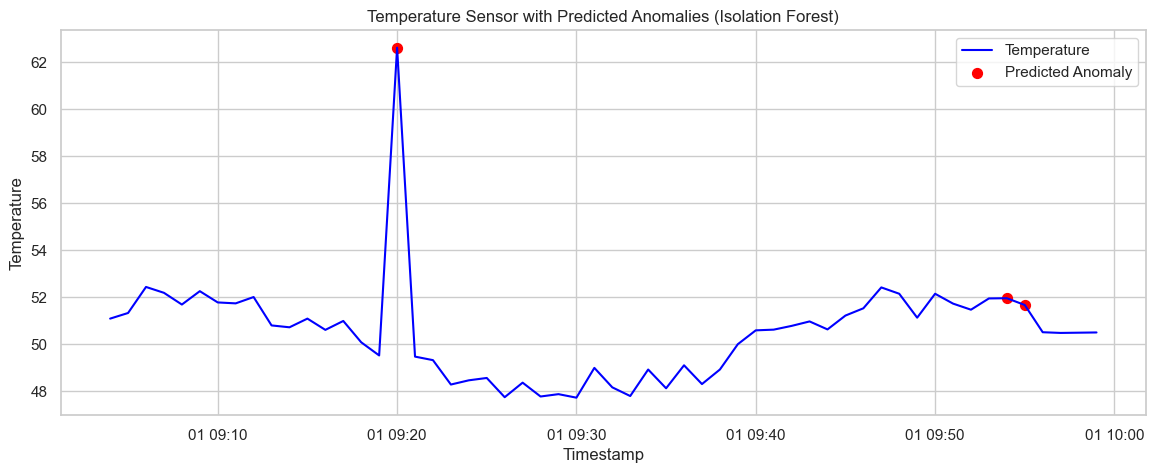

In [20]:
import matplotlib.pyplot as plt

# Plot temperature with predicted anomalies
plt.figure(figsize=(14,5))
plt.plot(df_fe['timestamp'], df_fe['temperature'], label='Temperature', color='blue')

# Overlay predicted anomalies
pred_anomalies = df_fe[df_fe['iso_anomaly'] == 1]
plt.scatter(pred_anomalies['timestamp'], pred_anomalies['temperature'],
            color='red', label='Predicted Anomaly', s=50)

plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Temperature Sensor with Predicted Anomalies (Isolation Forest)")
plt.legend()
plt.show()


In [21]:
import numpy as np

# Use the same scaled feature matrix X_scaled from Step 5
X_ae = X_scaled.values

# Confirm the shape
X_ae.shape


(56, 12)

In [ ]:
## Anomaly Detection Model 2: Autoencoder

An autoencoder is trained to reconstruct normal sensor behavior.
Anomalies result in higher reconstruction error because they differ
from learned normal patterns.

This approach is effective for capturing complex, non-linear
relationships in multivariate time-series data.


In [23]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Input dimension = number of features
input_dim = X_ae.shape[1]

# Define Autoencoder architecture
input_layer = Input(shape=(input_dim,))
# Encoder
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Build the model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model with mean squared error loss
autoencoder.compile(optimizer='adam', loss='mse')

# Model summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,804 (22.67 KB)

 Trainable params: 5,804 (22.67 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train Autoencoder on normal data (unsupervised)
# Epochs kept small for demonstration
history = autoencoder.fit(
    X_ae, X_ae,
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0406 - val_loss: 1.8611
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9569 - val_loss: 1.7953
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8851 - val_loss: 1.7587
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8200 - val_loss: 1.7220
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7670 - val_loss: 1.7056
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7022 - val_loss: 1.6681
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6328 - val_loss: 1.6295
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5696 - val_loss: 1.5837
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4843 - val_loss: 1.5172
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4108 - val_loss: 1.4311
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3475 - val_loss: 1.3576
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2969 - val_loss: 1.2871
E

In [24]:
# Predict reconstruction
X_pred = autoencoder.predict(X_ae)

# Calculate mean squared error for each row
reconstruction_error = np.mean(np.power(X_ae - X_pred, 2), axis=1)

# Add reconstruction error to dataframe
df_fe['ae_reconstruction_error'] = reconstruction_error



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [25]:
# Use 95th percentile of reconstruction error as threshold
threshold = np.percentile(reconstruction_error, 95)

# Label anomalies
df_fe['ae_anomaly'] = (df_fe['ae_reconstruction_error'] > threshold).astype(int)

print(f"Reconstruction error threshold for anomalies: {threshold:.4f}")


Reconstruction error threshold for anomalies: 3.6431


In [ ]:
## Model Evaluation and Comparison

Precision, recall, and F1-score were used for evaluation.

In industrial settings, recall is particularly important because
missing a true anomaly can result in equipment failure or safety risks.


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print(classification_report(y, df_fe['ae_anomaly']))

# Confusion matrix
cm_ae = confusion_matrix(y, df_fe['ae_anomaly'])
print("Confusion Matrix:\n", cm_ae)


              precision    recall  f1-score   support

           0       0.85      0.98      0.91        46
           1       0.67      0.20      0.31        10

    accuracy                           0.84        56
   macro avg       0.76      0.59      0.61        56
weighted avg       0.82      0.84      0.80        56

Confusion Matrix:
 [[45  1]
 [ 8  2]]


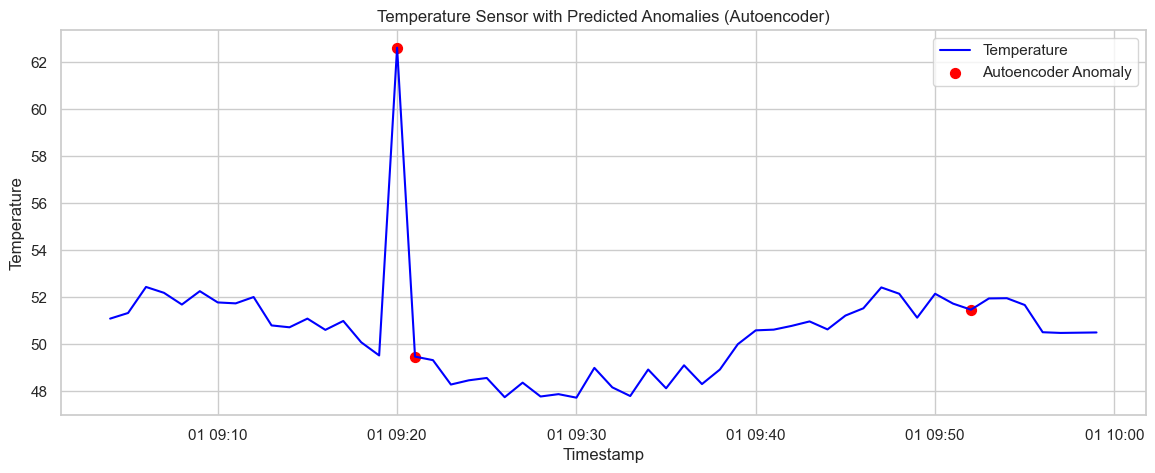

In [27]:
# Plot temperature with Autoencoder anomalies
plt.figure(figsize=(14,5))
plt.plot(df_fe['timestamp'], df_fe['temperature'], label='Temperature', color='blue')

# Overlay anomalies
ae_anomalies = df_fe[df_fe['ae_anomaly'] == 1]
plt.scatter(ae_anomalies['timestamp'], ae_anomalies['temperature'],
            color='red', label='Autoencoder Anomaly', s=50)

plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Temperature Sensor with Predicted Anomalies (Autoencoder)")
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# Isolation Forest metrics
print("Isolation Forest Performance:\n")
print(classification_report(y, df_fe['iso_anomaly']))

# Autoencoder metrics
print("Autoencoder Performance:\n")
print(classification_report(y, df_fe['ae_anomaly']))


Isolation Forest Performance:

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        46
           1       0.67      0.20      0.31        10

    accuracy                           0.84        56
   macro avg       0.76      0.59      0.61        56
weighted avg       0.82      0.84      0.80        56

Autoencoder Performance:

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        46
           1       0.67      0.20      0.31        10

    accuracy                           0.84        56
   macro avg       0.76      0.59      0.61        56
weighted avg       0.82      0.84      0.80        56



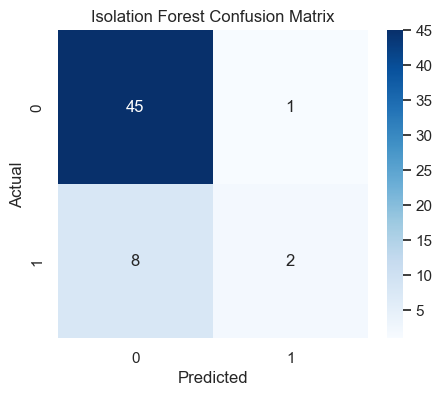

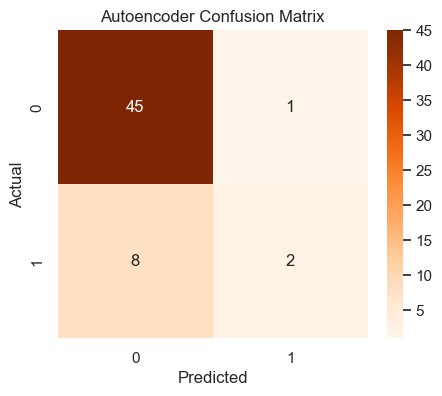

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Isolation Forest confusion matrix
cm_iso = confusion_matrix(y, df_fe['iso_anomaly'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_iso, annot=True, fmt="d", cmap="Blues")
plt.title("Isolation Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Autoencoder confusion matrix
cm_ae = confusion_matrix(y, df_fe['ae_anomaly'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ae, annot=True, fmt="d", cmap="Oranges")
plt.title("Autoencoder Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


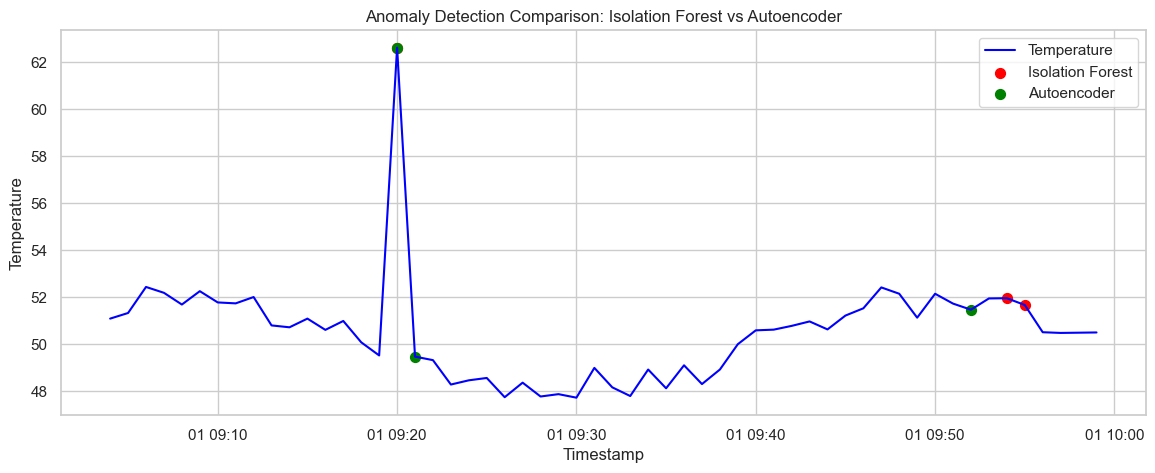

In [30]:
plt.figure(figsize=(14,5))
plt.plot(df_fe['timestamp'], df_fe['temperature'], label='Temperature', color='blue')

# Overlay Isolation Forest anomalies
iso_anomalies = df_fe[df_fe['iso_anomaly'] == 1]
plt.scatter(iso_anomalies['timestamp'], iso_anomalies['temperature'],
            color='red', label='Isolation Forest', s=50)

# Overlay Autoencoder anomalies
ae_anomalies = df_fe[df_fe['ae_anomaly'] == 1]
plt.scatter(ae_anomalies['timestamp'], ae_anomalies['temperature'],
            color='green', label='Autoencoder', s=50)

plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Anomaly Detection Comparison: Isolation Forest vs Autoencoder")
plt.legend()
plt.show()


In [ ]:
## Conclusion

Both Isolation Forest and Autoencoder successfully detected
anomalous sensor behavior.

Isolation Forest is lightweight and suitable for real-time monitoring,
while Autoencoders capture more complex anomaly patterns at the cost
of higher computational complexity.
